# How to use the package if the predicted survival curve (or cumulative density/mass curve) is not monotonic
Survival curves should be monotonic decreasing curves, ie. the survival probability should not increase with time. 

Most survival models (e.g. Cox proportional hazards model, Aalen's additive hazards model, etc.) guarantee that the predicted survival curve is monotonic. However, in some models, we may not be able to guarantee that the predicted survival curve is monotonic. 

For example, we have observed that the predicted survival curve from the [`CQRNN`](https://github.com/TeaPearce/Censored_Quantile_Regression_NN) model may not be monotonic.

To be able to use the `SurvivalEVAL` package for evaluation, we need to make sure that the predicted survival curve is monotonic. The following instructions show how to convert a non-monotonic survival curve to a monotonic one using the built-in functions in `SurvivalEVAL` package.

Let first synthesize some monotonic survival curves
1. We first generate some probability density functions (PDFs).
2. Then calculate the cumulative density functions (CDFs) from the PDFs.
3. Finally, we calculate the survival curves from the CDFs.

In [1]:
import numpy as np

np.random.seed(0)

time_bins = np.arange(0, 20, 1)
num_samples = 10
num_bins = len(time_bins) - 1

# generate pdf curves
pdfs = np.random.normal(0, 1, (num_samples, num_bins))
# using softmax to make sure that the pdfs are non-negative and sum to 1
pdfs = np.exp(pdfs)
pdfs = pdfs / np.sum(pdfs, axis=1, keepdims=True)

# calculate cdf curves
cdfs = np.cumsum(pdfs, axis=1)
# concatenate zeros at the front of cdfs
cdfs = np.concatenate([np.zeros((num_samples, 1)), cdfs], axis=1)

# calculate survival curves
survival_curves = 1 - cdfs

Then we synthesize some non-monotonic survival curves by randomly flipping the survival curves.

In real applications, the non-monotonicity may be caused by other reasons, e.g. the insufficient float-point numbers accuracy, the model is not well-trained, and etc.

In [2]:
# randomly flip survival curves
# set seed for reproducibility
np.random.seed(0)

flip_prob = 0.02
flip_mask = np.random.uniform(0, 1, (num_samples, num_bins + 1)) < flip_prob
survival_curves[flip_mask] = 1 - survival_curves[flip_mask]

Plot the synthesized non-monotonic survival curves

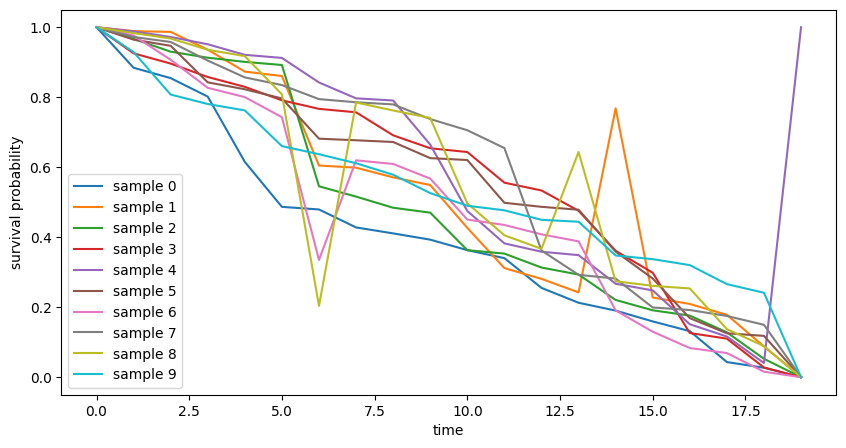

In [3]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
for i in range(num_samples):
    plt.plot(time_bins, survival_curves[i], label='sample {}'.format(i))
plt.xlabel('time')
plt.ylabel('survival probability')
plt.legend()
plt.show()

Check the monotonicity of the survival curves

In [4]:
from Evaluations.util import check_monotonicity

for i in range(num_samples):
    if check_monotonicity(survival_curves[i]):
        print('sample {}: monotonic'.format(i))
    else:
        print('sample {}: not monotonic'.format(i))

sample 0: monotonic
sample 1: not monotonic
sample 2: monotonic
sample 3: monotonic
sample 4: not monotonic
sample 5: monotonic
sample 6: not monotonic
sample 7: monotonic
sample 8: not monotonic
sample 9: monotonic


## Convert the non-monotonic survival curves to monotonic ones
The first method is `ceil`, which is to round up the survival curve to the nearest monotonic survival curve. 

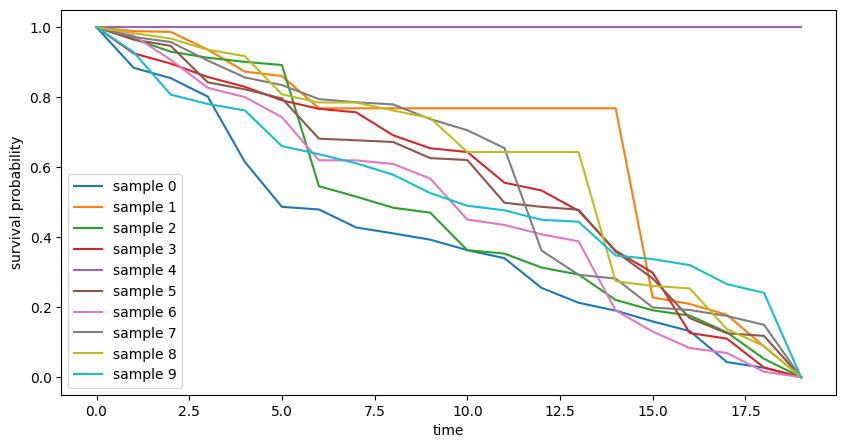

In [5]:
from Evaluations.util import make_monotonic

survival_curves_ceil = make_monotonic(survival_curves, time_bins, method='ceil')

# plot the monotonic survival curves
plt.figure(figsize=(10, 5))
for i in range(num_samples):
    plt.plot(time_bins, survival_curves_ceil[i], label='sample {}'.format(i))
plt.xlabel('time')
plt.ylabel('survival probability')
plt.legend()
plt.show()

The second method is `floor`, which is to round down the survival curve to the nearest monotonic survival curve.

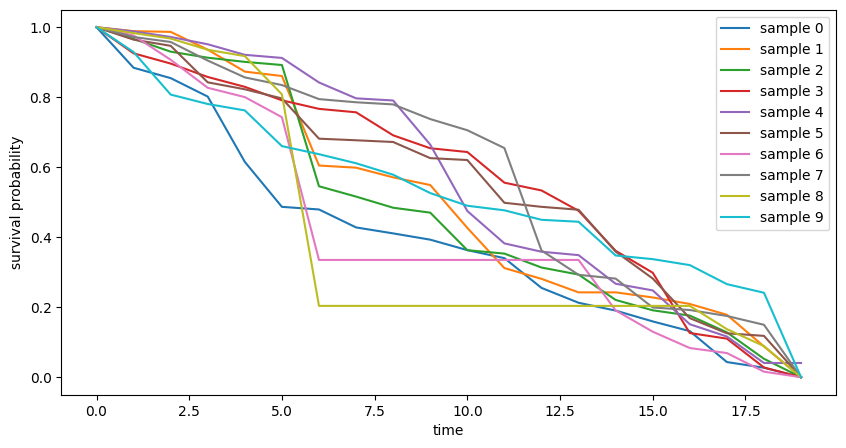

In [6]:
survival_curves_floor = make_monotonic(survival_curves, time_bins, method='floor')

# plot the monotonic survival curves
plt.figure(figsize=(10, 5))
for i in range(num_samples):
    plt.plot(time_bins, survival_curves_floor[i], label='sample {}'.format(i))
plt.xlabel('time')
plt.ylabel('survival probability')
plt.legend()
plt.show()

The third method is `bootstrap`, which is proposed in Chernozhukov et al. (2010) Quantile and Probability Curves Without Crossing, Econometrica. The idea is to use bootstrapping to approximate the monotonic survival curve.

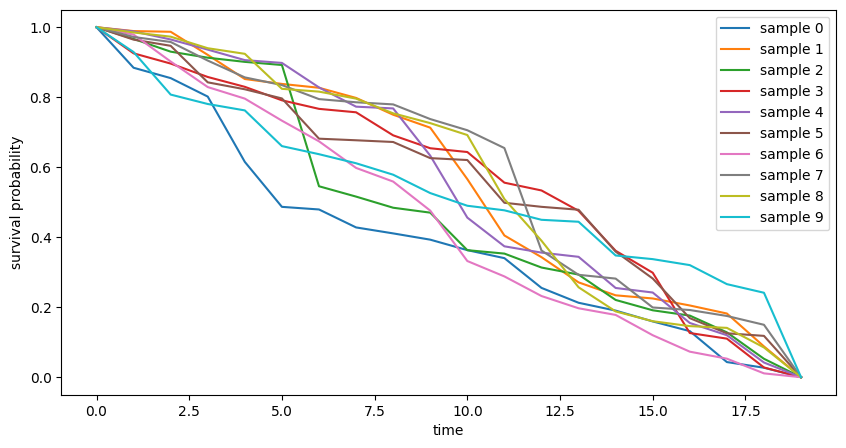

In [7]:
survival_curves_linear = make_monotonic(survival_curves, time_bins, method='bootstrap', seed=0)

# plot the monotonic survival curves
plt.figure(figsize=(10, 5))
for i in range(num_samples):
    plt.plot(time_bins, survival_curves_linear[i], label='sample {}'.format(i))
plt.xlabel('time')
plt.ylabel('survival probability')
plt.legend()
plt.show()

Visualize the original non-monotonic survival curve with the three monotonic survival curves. Take the second sample as an example.

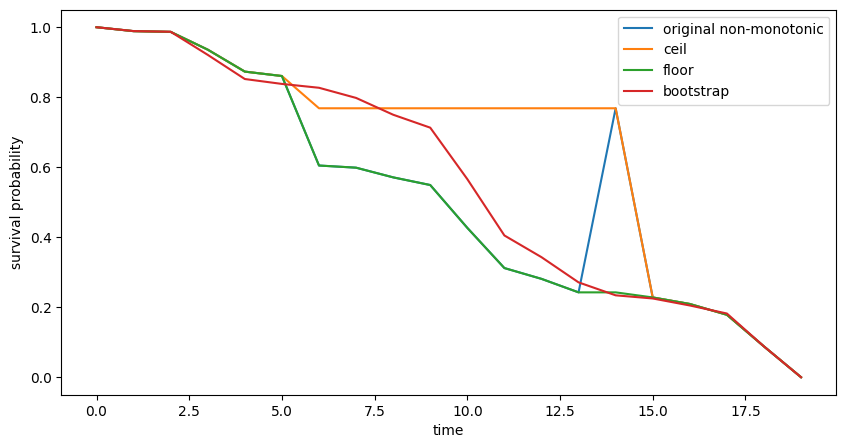

In [8]:
# plot the original non-monotonic survival curve
plt.figure(figsize=(10, 5))
plt.plot(time_bins, survival_curves[1], label='original non-monotonic')
# plot the three monotonic survival curves
plt.plot(time_bins, survival_curves_ceil[1], label='ceil')
plt.plot(time_bins, survival_curves_floor[1], label='floor')
plt.plot(time_bins, survival_curves_linear[1], label='bootstrap')
plt.xlabel('time')
plt.ylabel('survival probability')
plt.legend()
plt.show()